In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import copy
import os
import random

# --- CONFIGURATION ---
DATA_PATH = '/content/drive/MyDrive/adhd_deepfmri_aal.npy'
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-2  # Regularization
DROPOUT = 0.5        # High dropout for small medical datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed for reproducibility
SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# --- 1. DATASET CLASS ---
class ADHDDataset(Dataset):
    def __init__(self, time_series, labels):
        """
        Args:
            time_series: Numpy array of shape (N, 172, 90)
            labels: Numpy array of shape (N,)
        """
        # We need to swap dimensions for the Transformer
        # Original: (Time=172, Regions=90)
        # Transformer Expectation: (Sequence=Regions=90, Features=Time=172)
        # We treat Regions as 'Tokens' and Time as the 'Embedding'
        self.X = torch.FloatTensor(time_series).permute(0, 2, 1) # Result: (N, 90, 172)
        self.y = torch.LongTensor(labels)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- 2. DATA LOADING & PREPARATION ---
def load_data(path):
    print(f"Loading data from {path}...")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found at {path}")

    data = np.load(path, allow_pickle=True)

    # Extract arrays from list of dicts
    # Dict keys: 'time_series', 'pheno', 'label', 'site'
    X_list = []
    y_list = []
    sites_list = []

    for subject in data:
        X_list.append(subject['time_series'])
        y_list.append(subject['label'])
        sites_list.append(subject['site'])

    X = np.stack(X_list) # Shape: (N, 172, 90)
    y = np.array(y_list) # Shape: (N,)
    sites = np.array(sites_list)

    return X, y, sites

# --- 3. MODEL: BRAIN REGION TRANSFORMER ---
class BrainRegionTransformer(nn.Module):
    def __init__(self, num_regions=90, time_points=172, num_classes=2,
                 embed_dim=128, num_heads=4, num_layers=4, dropout=0.5):
        super(BrainRegionTransformer, self).__init__()

        # 1. Feature Projection: Map time-series (172) to latent dim (128)
        self.input_projection = nn.Linear(time_points, embed_dim)

        # 2. Positional Embedding (Learnable, since brain regions aren't strictly sequential like text)
        # +1 for the CLS token
        self.pos_embedding = nn.Parameter(torch.randn(1, num_regions + 1, embed_dim))

        # 3. CLS Token (Learned vector to aggregate global info)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True # Pre-norm usually stabilizes training
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 5. Classification Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, Regions=90, Time=172)

        b, r, t = x.shape

        # Project features: (B, 90, 128)
        x = self.input_projection(x)

        # Expand CLS token to batch size: (B, 1, 128)
        cls_tokens = self.cls_token.expand(b, -1, -1)

        # Concatenate CLS token to input: (B, 91, 128)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embedding
        x = x + self.pos_embedding

        # Pass through Transformer
        x = self.transformer_encoder(x)

        # Extract CLS token output (index 0)
        cls_output = x[:, 0, :]

        # Classify
        logits = self.classifier(cls_output)

        return logits

# --- 4. TRAINING UTILS ---
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader.dataset), accuracy, all_labels, all_preds

# --- 5. MAIN EXECUTION ---
if __name__ == "__main__":
    print(f"Running on device: {device}")

    # 1. Load Data
    try:
        X, y, sites = load_data(DATA_PATH)
        print(f"Data Loaded: X shape: {X.shape}, y shape: {y.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        exit()

    # 2. Split Data (Stratified by Site to prevent site bias)
    # We combine Label + Site to create a stratification key
    stratify_key = [f"{l}_{s}" for l, s in zip(y, sites)]

    # First: Train (80%) + Val/Test (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, stratify=stratify_key, random_state=SEED
    )

    # Second: Split Temp into Val (10%) and Test (10%)
    # Re-stratify based on y_temp (site info lost in arrays, but roughly kept)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
    )

    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    # 3. Create DataLoaders
    train_dataset = ADHDDataset(X_train, y_train)
    val_dataset = ADHDDataset(X_val, y_val)
    test_dataset = ADHDDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 4. Initialize Model
    model = BrainRegionTransformer(
        num_regions=90,
        time_points=172,
        embed_dim=64,   # Smaller dim for small dataset
        num_heads=4,
        num_layers=2,   # Fewer layers to prevent overfitting
        dropout=DROPOUT
    ).to(device)

    # Calculate Class Weights (Imbalance: Healthy 362, ADHD 275)
    count_0 = np.sum(y_train == 0)
    count_1 = np.sum(y_train == 1)
    weight_1 = count_0 / count_1
    class_weights = torch.FloatTensor([1.0, weight_1]).to(device)
    print(f"Class Weights: {class_weights}")

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    # 5. Training Loop
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    print("\nStarting Training...")
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_acc)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_brain_transformer.pth')

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    print("\nTraining Complete.")

    # 6. Final Evaluation
    print("Loading best model for testing...")
    model.load_state_dict(best_model_wts)
    test_loss, test_acc, true_labels, pred_labels = evaluate(model, test_loader, criterion, device)

    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['Healthy', 'ADHD']))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    print("Confusion Matrix:")
    print(cm)

Running on device: cuda
Loading data from /content/drive/MyDrive/adhd_deepfmri_aal.npy...
Data Loaded: X shape: (637, 172, 90), y shape: (637,)
Train: 509 | Val: 64 | Test: 64
Class Weights: tensor([1.0000, 1.3136], device='cuda:0')

Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 5/60 | Train Loss: 0.6954 Acc: 0.5333 | Val Loss: 0.6816 Acc: 0.6094
Epoch 10/60 | Train Loss: 0.6755 Acc: 0.5750 | Val Loss: 0.6749 Acc: 0.5625
Epoch 15/60 | Train Loss: 0.6768 Acc: 0.5813 | Val Loss: 0.6677 Acc: 0.5781
Epoch 20/60 | Train Loss: 0.6726 Acc: 0.5771 | Val Loss: 0.6638 Acc: 0.6094
Epoch 25/60 | Train Loss: 0.6671 Acc: 0.5917 | Val Loss: 0.6615 Acc: 0.6094
Epoch 30/60 | Train Loss: 0.6703 Acc: 0.5646 | Val Loss: 0.6597 Acc: 0.6250
Epoch 35/60 | Train Loss: 0.6635 Acc: 0.6104 | Val Loss: 0.6589 Acc: 0.6250
Epoch 40/60 | Train Loss: 0.6712 Acc: 0.5938 | Val Loss: 0.6584 Acc: 0.6406
Epoch 45/60 | Train Loss: 0.6675 Acc: 0.6021 | Val Loss: 0.6581 Acc: 0.6406
Epoch 50/60 | Train Loss: 0.6683 Acc: 0.5687 | Val Loss: 0.6579 Acc: 0.6406
Epoch 55/60 | Train Loss: 0.6667 Acc: 0.6021 | Val Loss: 0.6578 Acc: 0.6406
Epoch 60/60 | Train Loss: 0.6595 Acc: 0.6229 | Val Loss: 0.6577 Acc: 0.6406

Training Complete.
Loading best model for testing...

Final Test Accuracy: 0.5312

Class

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import random

# --- CONFIGURATION ---
DATA_PATH = '/content/drive/MyDrive/adhd_deepfmri_aal.npy'
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-2  # Regularization
DROPOUT = 0.5        # High dropout for small medical datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed for reproducibility
SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# --- 1. DATASET CLASS ---
class ADHDDataset(Dataset):
    def __init__(self, time_series, labels):
        """
        Args:
            time_series: Numpy array of shape (N, 172, 90)
            labels: Numpy array of shape (N,)
        """
        # We need to swap dimensions for the Transformer
        # Original: (Time=172, Regions=90)
        # Transformer Expectation: (Sequence=Regions=90, Features=Time=172)
        # We treat Regions as 'Tokens' and Time as the 'Embedding'
        self.X = torch.FloatTensor(time_series).permute(0, 2, 1) # Result: (N, 90, 172)
        self.y = torch.LongTensor(labels)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- 2. DATA LOADING & PREPARATION ---
def load_data(path):
    print(f"Loading data from {path}...")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found at {path}")

    data = np.load(path, allow_pickle=True)

    # Extract arrays from list of dicts
    # Dict keys: 'time_series', 'pheno', 'label', 'site'
    X_list = []
    y_list = []
    sites_list = []

    for subject in data:
        X_list.append(subject['time_series'])
        y_list.append(subject['label'])
        sites_list.append(subject['site'])

    X = np.stack(X_list) # Shape: (N, 172, 90)
    y = np.array(y_list) # Shape: (N,)
    sites = np.array(sites_list)

    return X, y, sites

# --- 3. MODEL: BRAIN REGION TRANSFORMER ---
class BrainRegionTransformer(nn.Module):
    def __init__(self, num_regions=90, time_points=172, num_classes=2,
                 embed_dim=128, num_heads=4, num_layers=4, dropout=0.5):
        super(BrainRegionTransformer, self).__init__()

        # 1. Feature Projection: Map time-series (172) to latent dim (128)
        self.input_projection = nn.Linear(time_points, embed_dim)

        # 2. Positional Embedding (Learnable, since brain regions aren't strictly sequential like text)
        # +1 for the CLS token
        self.pos_embedding = nn.Parameter(torch.randn(1, num_regions + 1, embed_dim))

        # 3. CLS Token (Learned vector to aggregate global info)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True # Pre-norm usually stabilizes training
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 5. Classification Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, Regions=90, Time=172)

        b, r, t = x.shape

        # Project features: (B, 90, 128)
        x = self.input_projection(x)

        # Expand CLS token to batch size: (B, 1, 128)
        cls_tokens = self.cls_token.expand(b, -1, -1)

        # Concatenate CLS token to input: (B, 91, 128)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embedding
        x = x + self.pos_embedding

        # Pass through Transformer
        x = self.transformer_encoder(x)

        # Extract CLS token output (index 0)
        cls_output = x[:, 0, :]

        # Classify
        logits = self.classifier(cls_output)

        return logits

# --- 4. TRAINING UTILS ---
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader.dataset), accuracy, all_labels, all_preds

# --- 6. VISUALIZATION UTILS ---
def plot_learning_curves(history, save_path='learning_curves.png'):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Learning curves saved to {save_path}")
    plt.close()

def plot_confusion_matrix(cm, classes, save_path='confusion_matrix.png'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(save_path)
    print(f"Confusion matrix saved to {save_path}")
    plt.close()

# --- 5. MAIN EXECUTION ---
if __name__ == "__main__":
    print(f"Running on device: {device}")

    # 1. Load Data
    try:
        X, y, sites = load_data(DATA_PATH)
        print(f"Data Loaded: X shape: {X.shape}, y shape: {y.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        exit()

    # 2. Split Data (Stratified by Site to prevent site bias)
    # We combine Label + Site to create a stratification key
    stratify_key = [f"{l}_{s}" for l, s in zip(y, sites)]

    # First: Train (80%) + Val/Test (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, stratify=stratify_key, random_state=SEED
    )

    # Second: Split Temp into Val (10%) and Test (10%)
    # Re-stratify based on y_temp (site info lost in arrays, but roughly kept)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
    )

    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    # 3. Create DataLoaders
    train_dataset = ADHDDataset(X_train, y_train)
    val_dataset = ADHDDataset(X_val, y_val)
    test_dataset = ADHDDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 4. Initialize Model
    model = BrainRegionTransformer(
        num_regions=90,
        time_points=172,
        embed_dim=64,   # Smaller dim for small dataset
        num_heads=4,
        num_layers=2,   # Fewer layers to prevent overfitting
        dropout=DROPOUT
    ).to(device)

    # Calculate Class Weights (Imbalance: Healthy 362, ADHD 275)
    count_0 = np.sum(y_train == 0)
    count_1 = np.sum(y_train == 1)
    weight_1 = count_0 / count_1
    class_weights = torch.FloatTensor([1.0, weight_1]).to(device)
    print(f"Class Weights: {class_weights}")

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    # 5. Training Loop
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\nStarting Training...")
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_acc)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_brain_transformer.pth')

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    print("\nTraining Complete.")

    # 6. Final Evaluation
    print("Loading best model for testing...")
    model.load_state_dict(best_model_wts)
    test_loss, test_acc, true_labels, pred_labels = evaluate(model, test_loader, criterion, device)

    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['Healthy', 'ADHD']))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    print("Confusion Matrix:")
    print(cm)

    # Plot Results
    plot_learning_curves(history)
    plot_confusion_matrix(cm, classes=['Healthy', 'ADHD'])

Running on device: cuda
Loading data from /content/drive/MyDrive/adhd_deepfmri_aal.npy...
Data Loaded: X shape: (637, 172, 90), y shape: (637,)
Train: 509 | Val: 64 | Test: 64
Class Weights: tensor([1.0000, 1.3136], device='cuda:0')

Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 5/60 | Train Loss: 0.6954 Acc: 0.5333 | Val Loss: 0.6816 Acc: 0.6094
Epoch 10/60 | Train Loss: 0.6755 Acc: 0.5750 | Val Loss: 0.6749 Acc: 0.5625
Epoch 15/60 | Train Loss: 0.6768 Acc: 0.5813 | Val Loss: 0.6677 Acc: 0.5781
Epoch 20/60 | Train Loss: 0.6726 Acc: 0.5771 | Val Loss: 0.6638 Acc: 0.6094
Epoch 25/60 | Train Loss: 0.6671 Acc: 0.5917 | Val Loss: 0.6615 Acc: 0.6094
Epoch 30/60 | Train Loss: 0.6703 Acc: 0.5646 | Val Loss: 0.6597 Acc: 0.6250
Epoch 35/60 | Train Loss: 0.6635 Acc: 0.6104 | Val Loss: 0.6589 Acc: 0.6250
Epoch 40/60 | Train Loss: 0.6712 Acc: 0.5938 | Val Loss: 0.6584 Acc: 0.6406
Epoch 45/60 | Train Loss: 0.6675 Acc: 0.6021 | Val Loss: 0.6581 Acc: 0.6406
Epoch 50/60 | Train Loss: 0.6683 Acc: 0.5687 | Val Loss: 0.6579 Acc: 0.6406
Epoch 55/60 | Train Loss: 0.6667 Acc: 0.6021 | Val Loss: 0.6578 Acc: 0.6406
Epoch 60/60 | Train Loss: 0.6595 Acc: 0.6229 | Val Loss: 0.6577 Acc: 0.6406

Training Complete.
Loading best model for testing...

Final Test Accuracy: 0.5312

Class

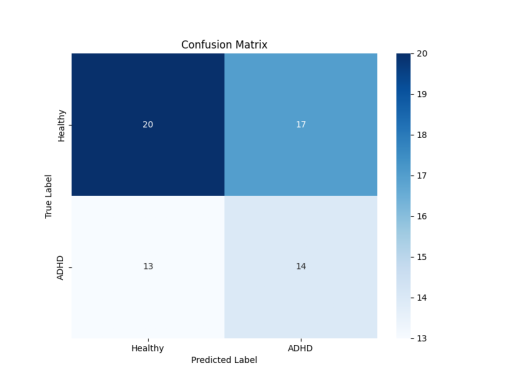

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/confusion_matrix.png")
plt.imshow(img)
plt.axis("off")  # hides axes
plt.show()


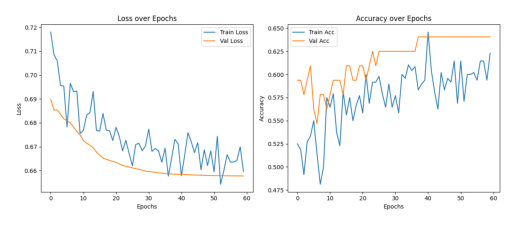

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/learning_curves.png")
plt.imshow(img)
plt.axis("off")  # hides axes
plt.show()
